<a href="https://colab.research.google.com/github/AndreasMing/Learning/blob/main/NN_Micrograd/NeuralnetsWithMicrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural nets with micrograd
This is a Notebook by [Andreas Ming](https://github.com/AndreasMing) to the free lecture [The spelled-out intro to neural networks and backpropagation: building micrograd](https://youtu.be/VMj-3S1tku0) by [Andrey Karpathy](https://github.com/karpathy).

In [ ]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Understanding the derivative

## Derivative of a function with a single input

$$3x^2 - 4x + 5$$

In [ ]:
def f(x):
  return 3*x**2 - 4*x +5

In [ ]:
f(3.0)

20.0

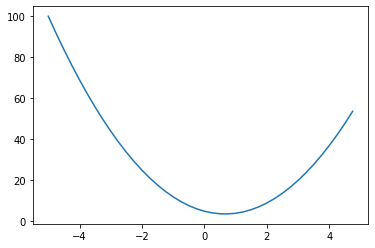

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Normally derivatives are derived directly from the mathematical expression of the base function. This is not done with neural networks. The fundemental definition of a derivative is stated as follows:

$$\frac{dy}{dx} = \lim_{h\to 0}\frac{f(x+h) - f(x)}{h}$$

By knowing this, the derivative can be derived by changeing the input by a small amount. Per definition the step of $h$ would be infinitly small.


In [ ]:
h = 0.001
x = 3.0         # derviative at this point
print('x = ', x, ' h = ', h)
print('f(x) = ', f(x))
print('f(x + h) = ', f(x + h))
print('dy/dx = ', (f(x+h)-f(x))/h)

x =  3.0  h =  0.001
f(x) =  20.0
f(x + h) =  20.014003000000002
dy/dx =  14.00300000000243


## Derivative of a function with multiple inputs
Functions with a single input are fairly easy to derive mathematically, this changes with functions with multiple inputs and neural nets have many of them.

In [ ]:
h = 0.001

# inputs (Point of derivation)
a = 2.0
b = -3.0
c = 10.0

# function
def f(a, b, c):
 return a*b + c

# derive
d1 = f(a, b, c)
print('d1 = ', d1)
c += h              # with respect to
d2 = f(a, b, c)
print('d2 = ', d2)
print('slope = ', (d2-d1)/h)

d1 =  4.0
d2 =  4.0009999999999994
slope =  0.9999999999994458


# Value class in micrograd

Micrograd provides a class *Value* for easy implementation and tracking of neural propagation. It initialy behaves as a normal scalar.

* Attribute ``data`` consists of the scalar value
* ``_prev`` provides a linked list along all of the operations
* ``_op`` stores the operation which lead to this node
* ``label`` is for visualization and documentation purposes for the function ``draw_dot()`` later on
* ``grad`` is the derivative in respect to a inputchange
* ``_backward`` stores the derivation of the nodes function for backpropagation

**``grad``** describes how the output of a linked list of operations changes with the changes of the value of the corresponding node. The determination of these values is called **backpropagation**.



In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label = ''):# provide values for the attributes at runtime
    self.data = data
    self.grad = 0.0                 # affection of this value to the output
    self._backward = lambda: None   # function for backpropagation
    self._prev = set(_children)     # children variable keeps track of the values
                                    # which lead to this result
    self._op = _op                  # keeps track of the operations
    self.label = label              # for visualization purposes

  def __repr__(self):             # overwrites the standard return of the object
    return f"Value(data={self.data})"

  def __add__(self, other):       # what to do if two value objects are added
    other = other if isinstance(other, Value) else Value(other)   # for usage with scalars not defined as values (eg. a + 1)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad    # applying chainrule on a sum-node
      other.grad += 1.0 * out.grad
    out._backward = _backward       # store the function for backpropagation
    return out

  def __neg__(self):              # -self
    return self * -1

  def __sub__(self, other):       # self - other
    return self + (-other)

  def __radd__(self, other):      # fallback for other * self
    return self * other

  def __mul__(self, other):       # what to do if two value objects are multiplied
    other = other if isinstance(other, Value) else Value(other)   # for usage with scalars not defined as values (eg. a * 2)
    out =  Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad   # applying chainrule on times-node
      other.grad += self.data * out.grad
    out._backward = _backward     # store the function for backpropagation
    return out

  def __rmul__(self, other):      # fallback for other * self
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * self.data**(other-1) * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other):   # self / other
    return self * other**-1

  def tanh(self):                 # implementing the tanh function
    x = self.data
    tanh = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out =  Value(tanh, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - tanh**2) * out.grad # derviative of tanh
    out._backward = _backward     # store the function for backpropagation
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad  # derive e** and chainrule
    out._backward = _backward
    return out

  def backward(self):
    topo = []                     # build out topological order
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0               # topmost gradient is dself/dself = 1

    for node in reversed(topo):   # define grad beginning from top
      node._backward()

  

## Vizualisation
See [Sourcecode](https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb)

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

$a$ and $b$ are acting as node inputs, where as $c$ to $f$ act as the weights within the neural net. $grad$ describes how a valuechange of the corresponding node is influencing the output value.

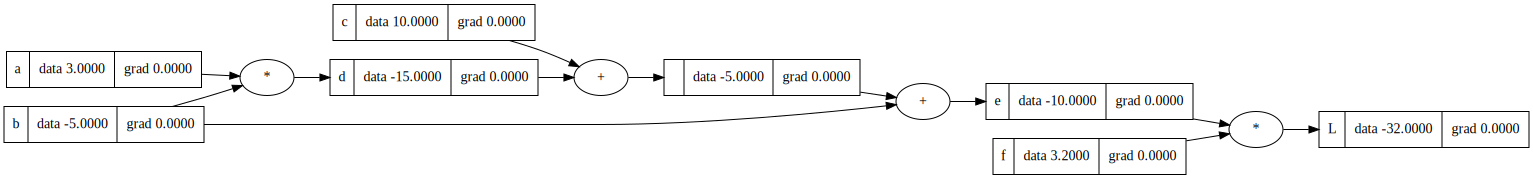

In [ ]:
# testing
a = Value(3.0, label = 'a')
b = Value(-5.0, label = 'b')
c = Value(10.0, label = 'c')
d = a*b; d.label = 'd'
e = d+c+b; e.label = 'e'
f = Value(3.2, label = 'f')
L = e*f; L.label = 'L'

# visualization
draw_dot(L)

## Determination of the gradient

### Manual backpropagation example #1: Simple expression

In [ ]:
# testing
a = Value(3.0, label = 'a')
b = Value(-5.0, label = 'b')
c = Value(10.0, label = 'c')
d = a*b; d.label = 'd'
e = d+c; e.label = 'e'
f = Value(3.2, label = 'f')
L = e*f; L.label = 'L'
print('L: \t', L)
print('_prev:\t', L._prev)
print('_op: \t', L._op)

L: 	 Value(data=-16.0)
_prev:	 {Value(data=3.2), Value(data=-5.0)}
_op: 	 *


First of we are going to determine the grad values by manual backpropagation:

* ``grad`` of $L$ will always be $1.0$ because we are calculating $\frac{dL}{dL} = 1$
* ``e.gard`` $= \frac{dL}{de} = \frac{d}{de}f*e = f$
* ``f.gard`` $= \frac{dL}{df} = \frac{d}{df}f*e = e$

*local derivative of the **Sum**-node, because we already know how $e$ is impacting $L$:*
* calculate $\frac{de}{dc} = \frac{d}{dc}c+d = 1$
* and by symmetry $\frac{de}{dd} = 1$

by applying the chainrule: **(Sum-nodes routes the derivative from the upper node to the two adjoining values "distributor")**
* ``c.grad`` $= \frac{dL}{dc} = \frac{dL}{de} * \frac{de}{dc} = e.grad * 1 = e.grad$
* ``d.grad`` $= \frac{dL}{dd} = \frac{dL}{de} * \frac{de}{dd} = e.grad * 1 = e.grad$

*local gradient of **Times**-node: (likewise as on the first node*
* $\frac{dd}{da} = \frac{d}{da}a*b = b$
* $\frac{dd}{db} = \frac{d}{db}a*b = a$

by appying the chainrule:
* ``a.grad`` $= \frac{dL}{da} = \frac{dL}{dd} * \frac{dd}{da} = d.grad * b$
* ``b.grad`` $= \frac{dL}{db} = \frac{dL}{dd} * \frac{dd}{db} = d.grad * a$

In [ ]:
L.grad = 1
e.grad = f.data
f.grad = e.data
c.grad = e.grad
d.grad = e.grad
a.grad = d.grad * b.data
b.grad = d.grad * a.data


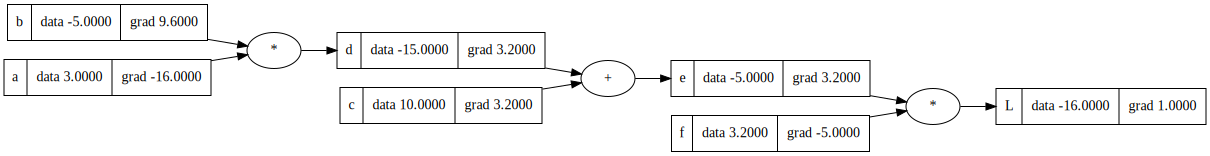

In [ ]:
draw_dot(L)

## Manual backpropagation example #2: a neuron
First check [Quick intro to neurons](https://colab.research.google.com/github/AndreasMing/Learning/blob/main/NeuralnetsWithMicrograd.ipynb#scrollTo=TjxcqCslCnDr&line=1&uniqifier=1)

The following code lays out the basic maths of a neuron:

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b                   # broke up into smaller steps
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'       # cell boday raw activation w/o activation function
o = n.tanh(); o.label = 'o'           # output axon

In [ ]:
# calculate derivatives by hand
o.grad = 1                      # derivative by itself
n.grad = 1 - o.data**2          # do/dn = 1 - tanh()**2

b.grad = n.grad                 # a plus is a distributor of gradient (n.grad*1)
x1w1x2w2.grad = n.grad          # n.grad * 1

x1w1.grad = x1w1x2w2.grad       # a plus is a distributor of gradient (n.grad*1*1)
x2w2.grad = x1w1x2w2.grad       # n.grad * 1 * 1

x1.grad = x1w1.grad * w1.data   # d/dx1 x1*w1 = w1      # chainroule: w1*x1w1.grad
w1.grad = x1w1.grad * x1.data   # symmetrical

x2.grad = x2w2.grad * w2.data   # d/dx2 x2*w2 = w2      # chainroule: w2*x2w2.grad
w2.grad = x2w2.grad * x2.data   # symmetrical


See [Implementing the backward function](https://colab.research.google.com/github/AndreasMing/Learning/blob/main/NeuralnetsWithMicrograd.ipynb#scrollTo=NEZlvYVsb3P_&line=4&uniqifier=1)

In [ ]:
# calculate derivatives by function
o.grad = 1.0        # initialize the topmost grad
o._backward()   
n._backward() 
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()


In [ ]:
# calculate derivatives by backward function
o.backward()

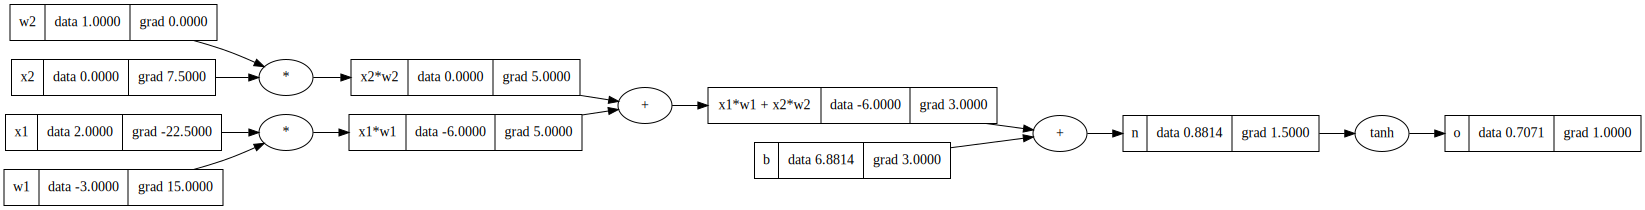

In [ ]:
# visualization
draw_dot(o)

## Implementing the backward function
For the implementation of the backward function on a whole expression graph we first have to perform a [topological sort](https://en.wikipedia.org/wiki/Topological_sorting).

This code is implemented in the [Value class](https://colab.research.google.com/github/AndreasMing/Learning/blob/main/NeuralnetsWithMicrograd.ipynb#scrollTo=eTvITsraSYKy&line=30&uniqifier=1)

In [ ]:
# topological sort algorithm
topo = []
visited = set()

def build_topo(v):            # topological sort function
  if v not in visited :
    visited.add(v)
    for child in v._prev:     # go through all children
      build_topo(child)
    topo.append(v)

# test
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [ ]:
o.grad = 1.0      # topmost gradient must be set manually

for node in reversed(topo):   # coming from the top
  node._backward()

## A bug when useing one node multiple times
There appears a bug when a node is used multiple times and the ``_backward`` in [Value class](https://colab.research.google.com/github/AndreasMing/Learning/blob/main/NeuralnetsWithMicrograd.ipynb#scrollTo=eTvITsraSYKy&line=30&uniqifier=1) is defined
```
def _backward():
    self.grad = 1.0 * out.grad    # applying chainrule on a sum-node
    other.grad = 1.0 * out.grad
```
When the following code is executed:
```
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
print('a.grad = ', a.grad)
```
The output is ``a.grad = 1.0`` which is wrong. The correct gradient would be $2$.

This bug appears when the ``backwards()`` function is called and a node is used multiple times, the ``.grad`` value will be overwritten. To tackle this bug the gradients must simply be added to the already present gradient:
```
def _backward():
    self.grad += 1.0 * out.grad    # applying chainrule on a sum-node
    other.grad += 1.0 * out.grad
```

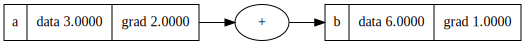

In [ ]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)


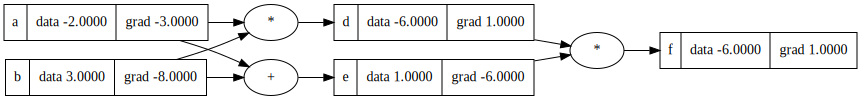

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'
f.backward()
draw_dot(f)

## Breaking up tanh()
Mathematical expressions can be implemented with different levels of depth. This can be illustrated by breaking up the tanh() function.

### With more mathematical operations
We implement tanh with basic mathematical expressions:
$$\tanh{x} = \frac{e^{2x}-1}{e^{2x}+1}$$

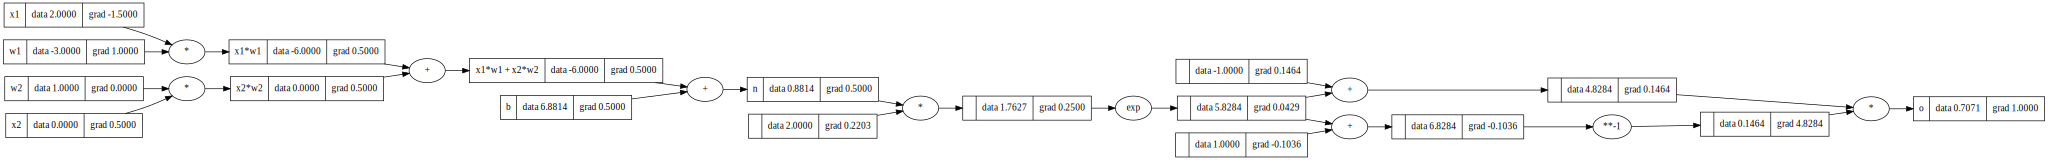

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b                   # broke up into smaller steps
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'       # cell boday raw activation w/o activation function
# breaking up tanh
e = (2*n).exp()
o = (e - 1)/(e + 1)
o.label = 'o'           # output axon
o.backward()
draw_dot(o)

### Working with **PyTorch**
PyTorch is a library which includes the same capabilities as micrograd. In the following section the above example will illustrate this.

In comparison to micrograd, PyTorch is working with Tensors (Matricies) rather than with scalars. For illustration purposes, the following example only consists of 1x1 matricies. Additionally gradients are ``FALSE`` by default.

In [ ]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2 grad', x2.grad.item())
print('w2 grad', w2.grad.item())
print('x1 grad', x1.grad.item())
print('w1 grad', w1.grad.item())



0.7071066904050358
---
x2 grad 0.5000001283844369
w2 grad 0.0
x1 grad -1.5000003851533106
w1 grad 1.0000002567688737


# Quick intro to neurons
A quick intro to neurons and its basic biological and mathematical modelling can be found on the [cs231n Lecture Page](https://cs231n.github.io/neural-networks-1/) by Stanford university.

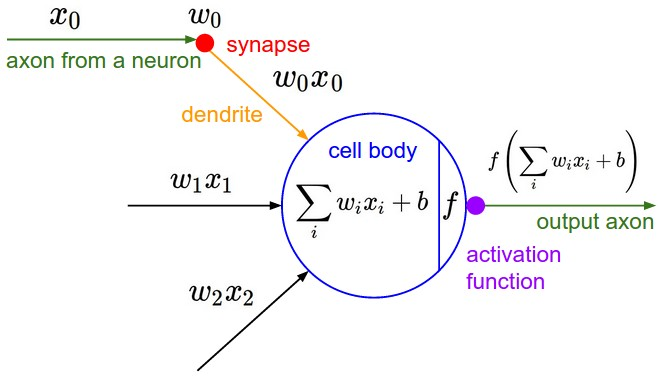

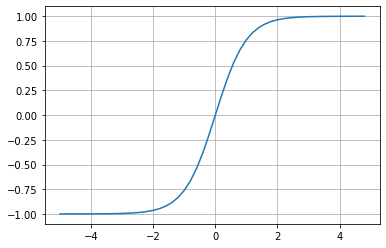

In [ ]:
# example of the tanh activation function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

As shown the ``tanh`` function squashes a given input inbetween $-1.0$ and $1.0$. Also see [Hyperbolic functions](https://en.wikipedia.org/wiki/Hyperbolic_functions)

### Building a neural net library
In this section we build a neural net library (multi-layer perceptron) in micrograd. The basic architecture is based on the PyTorch API.

Neural nets are just a specific class of mathematical expressions.

## Single neuron

In [ ]:
class Neuron:
  def __init__(self, nin):      # number of inputs
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]    # initialize a random weight for every input
    self.b = Value(random.uniform(-1,1))                          # initialize a random bias

  def __call__(self, x):        # n(x)                            # forward pass of the neuron
    # w * x + b                 # dot product of w, x plus b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)       # cell body function
    out = act.tanh()                                              # activation function
    return out

  def parameters(self):         # returns the parameter scalars
    return self.w + [self.b]

In [ ]:
# testing
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9994098321370631)

## Layer of neurons
Now we will define a single layer of neurons after the following schematic:
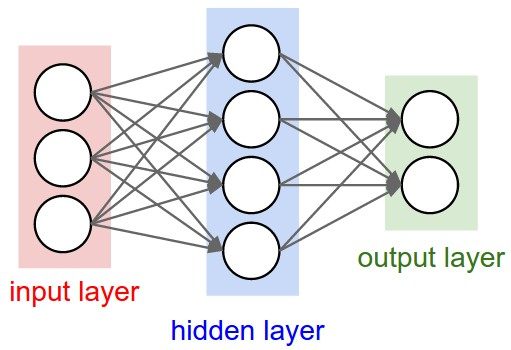

In [ ]:
class Layer:
  def __init__(self, nin, nout):  # number of inputs, number of outputs
    self.neurons = [Neuron(nin) for _ in range(nout)]   # a neuron per output

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]                 # all output activation functions
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()] # packs up parameters of all neurons


In [ ]:
# testing
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.7778525210122677),
 Value(data=-0.7707501643598426),
 Value(data=-0.9914097723944081)]

## Multy Layer Perceptron
Next up is a class for the multy layer perceptron, in other words, multiple layers like follows:
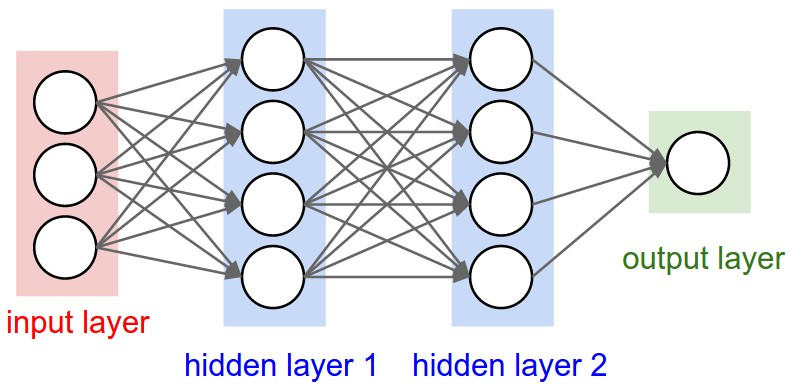

In [ ]:
class MLP:
  def __init__(self, nin, nouts):   # number of inputs, list outputs (entry per layer)
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()] # packs up parameters of all layers

In [ ]:
# implementation of the architecture above
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.9004851399615098)

# Backpropagation of a MLP (**loss function**)

By creating a tiny dataset we can "train" our first neural network implemented in the previous chapter. For this we have a dataset ``xs`` which consists of four possible inputs and another dataset ``ys`` which has the four desired outputs for those inputs.

In [ ]:
# data definition
xs = [[2.0,  3.0, -1.0],      # possible inputs
      [3.0, -1.0,  0.5],
      [0.5,  1.0,  1.0],
      [1.0,  1.0, -1.0]]

ys = [1.0, -1.0, -1.0, 1.0]   # desired targets

In [ ]:
# predictions untrained
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9004851399615098),
 Value(data=0.9561075068587284),
 Value(data=0.8747448228616868),
 Value(data=0.9566407336850707)]

A untrained network will output random numbers. For a better performance, the weights must be tuned in a way so the outputs better match the desired targets.

A trick which is used in deeplearning is to calculate a single number that measures the total performance. This number is called the **loss**. Over the course of a training (tuneing the weights) the goal is to minimize the loss.

In [ ]:
# caluclate loss
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print('loss = ', loss)

# loss backpropagation
loss.backward()     # backpropagation through the loss function and four forward passes of the network

print('grad = ', n.layers[0].neurons[0].w[0].grad)  # gradient of the first weight of the first neuron of the first layer
print('data = ', n.layers[0].neurons[0].w[0].data)  # value of the corresponding input

loss =  Value(data=7.342904755211137)
grad =  -0.16621853884657203
data =  -0.9676347523776418


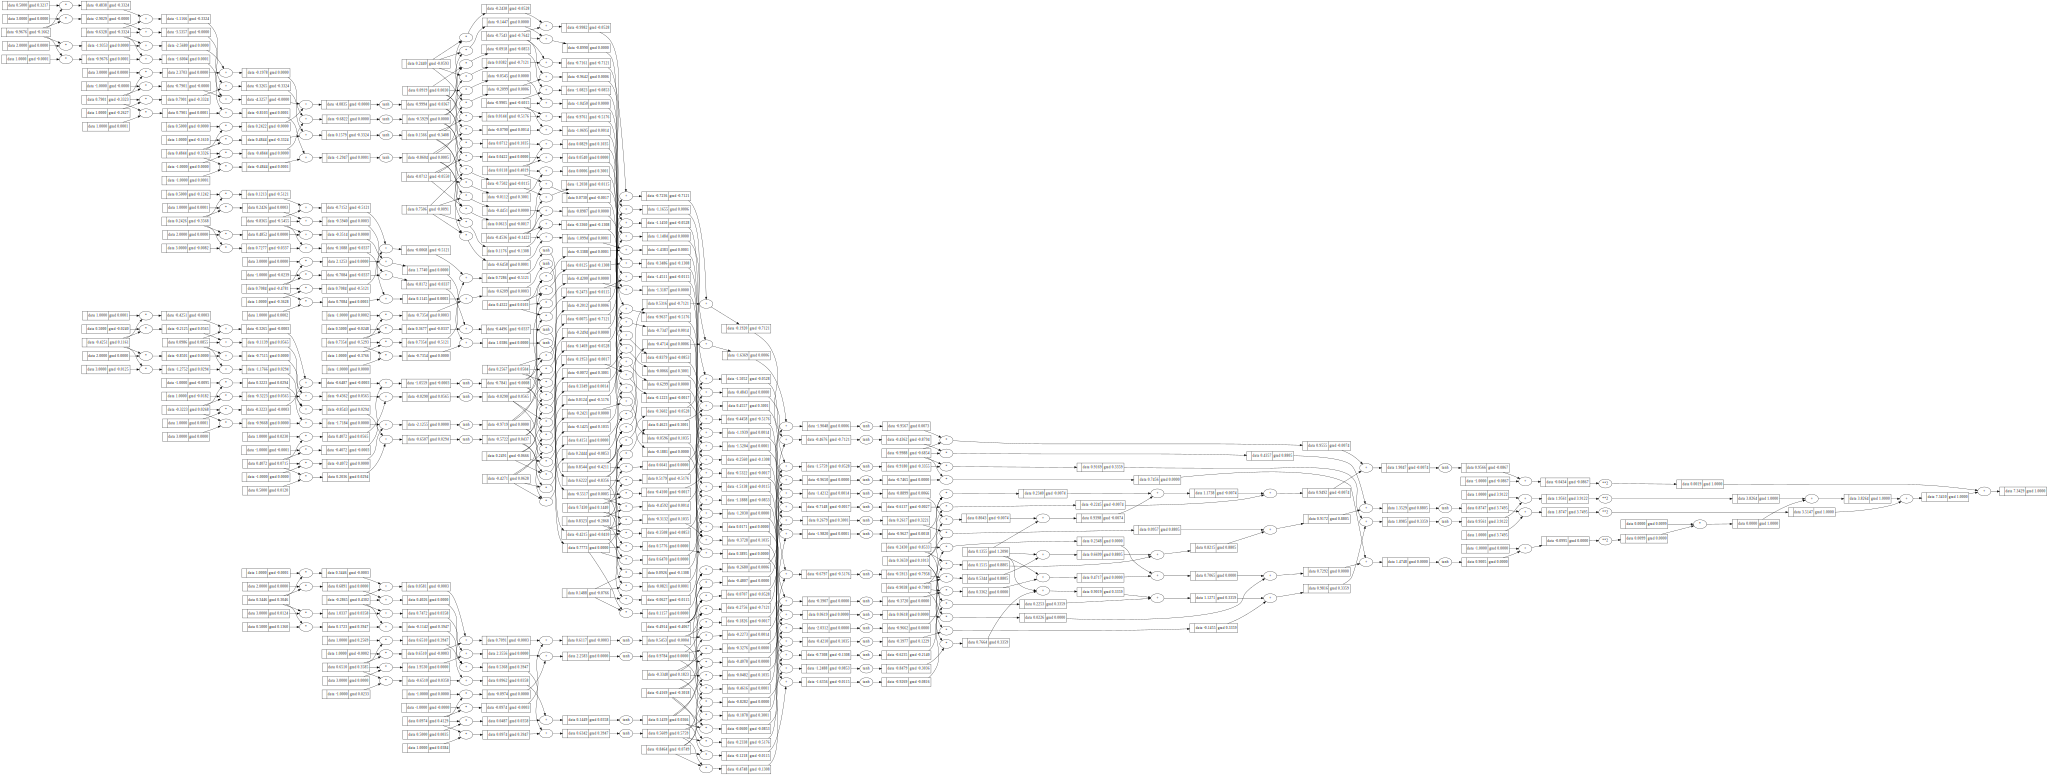

In [ ]:
draw_dot(loss)      # show the whole mathematical tree of the loss function and four forward passes of the network

## Gradient descent (**training**)
What we no have is a datatree, which consists of four forwardpasses of the network summed up and its loss function. Through backpropagation ``loss.backward()`` we get the gradient, or derivative, of a single weight, which describes how a small change will *change the loss* **not** the output of the network as before.

What we're now working on is to minimize the loss function. This can be achieved by changing weights bei a negative factor of its gradient.

**Important:** After every training loop the gradients must be reset, because else they're adding up over the course of the training.

GradientDescentGradientStep.svg

In [ ]:
print('loop\tloss')
# training loop
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  #print('prediction:', ypred)     # should 1.0, -1.0, -1.0, 1-0

  # backward pass
  for p in n.parameters():  # zero grad (because gradients are adding up)
    p.grad = 0.0
  loss.backward()

  # gradient descend
  learing_rate = 1.0- 0.9*k/100     # learning rate decay
  for p in n.parameters():
    p.data += -0.05 * p.grad

  # debug
  print(k, '.\t', loss.data)

loop	loss
0 .	 7.342904755211137
1 .	 6.899082695756308
2 .	 5.728441225421849
3 .	 3.3706423887795154
4 .	 0.5958531844564776
5 .	 0.35547860818526433
6 .	 0.2500087300364858
7 .	 0.19101132456648817
8 .	 0.1531894488233923
9 .	 0.12714690751452445
10 .	 0.10824939942656389
11 .	 0.09397677107900641
12 .	 0.0828532151919549
13 .	 0.07396226620126309
14 .	 0.06670713625045982
15 .	 0.06068371335271767
16 .	 0.05560925961543553
17 .	 0.05128039567621834
18 .	 0.04754730446977322
19 .	 0.04429732495817724


In [ ]:
ypred

[Value(data=-0.6006976514279224),
 Value(data=-0.8939995830156124),
 Value(data=-0.8939802391515969),
 Value(data=0.8522805129071976)]